## 1. Settings 

In [43]:
import warnings
warnings.filterwarnings("ignore")
import os,pickle,sys,re,glob
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import RepeatedStratifiedKFold

from venn import venn
from importlib import reload
#customized module
from fun import network_analysis, predictive_model, validation
from fun import utilities as ut
%matplotlib inline

cwd = os.getcwd()
#datapath=cwd+'/../working-folder'
datapath='/efs/bioinformatics/projects/tb-gene-signature/working-folder'
outputpath=cwd+'/data'
#normalized gene expression data
nor_exp_data=datapath+'/normalized-data'
#final model directory
#final_ml_dir = datapath+'/pickled-files/final-ML-model/opt_score_rocauc'
final_ml_dir = '/efs/bioinformatics/projects/tb-gene-signature-publish/working-folder/pickled-files/final-ML-model/opt_score_rocauc'
#validation data directory
valdata_dir = datapath+'/../validation-dataset'
pickled_objects_dir = datapath+'/pickled-files'
#data to be shared in the publication
publication_dir=outputpath

#For coding, if necessary
random_state=1#for creating randomized model
cpu=60 #cpu=-1 use all processors
reload(validation);reload(predictive_model);reload(ut)
gAssem=network_analysis.geneAssemClass(cwd,datapath,outputpath)
gpmod=predictive_model.predModelClass(cwd,datapath,outputpath,pickled_objects_dir,random_state,cpu)
gval=validation.valModelClass(cwd,datapath,outputpath,random_state,valdata_dir)
#data
rescale=1

## 2. Load the lists for validation datasets, our training models and published models

In [33]:
datasets=pd.read_csv(cwd+'/validate_data_list.csv',index_col=0) 
model_list=pd.read_csv(final_ml_dir+'/final_model_summary.csv',index_col=0) 
model_list['model']=['Full model','Reduced model']
#Final model for validation
model_list.to_csv(publication_dir+'/final_model_summary.csv',index=True)
pubmodel_list=pd.DataFrame([],columns=['model','# features','parameters','features'],index=range(1,5))
pubmodel_list.loc[1,:]=['Sweeney 3', 3, '(GBP5 + DUSP3)/2 − KLF2','GBP5,DUSP3,KLF2']
pubmodel_list.loc[2,:]=['RISK 6', 6, 'geoMean(GBP2,FCGR1B, SERPING1) - geoMean(TUBGCP6,TRMT2A,SDR39U1)','GBP2,FCGR1B,SERPING1,TUBGCP6,TRMT2A,SDR39U1']
pubmodel_list.loc[3,:]=['BATF2', 1, 'BATF2','BATF2']
pubmodel_list.loc[4,:]=['Suliman 4', 4, '(GAS6+SEPT4)-(CD1C+BLK)','GAS6,SEPT4,CD1C,BLK']

##### Validation datasets

In [10]:
datasets

,Dataset_ID,Platform,Size,PRJNA_ID
Name,,,,
Infect_subACS,GSE116014,microarray,85,NaN
Progress_ACS,GSE79362,RNAseq,214,PRJNA315611
Progress_GC6,GSE94438,RNAseq,418,PRJNA369684
Progress_Leicester,GSE107995,RNAseq,71,PRJNA422124
Progress_London,E-MTAB-6845,microarray,108,NaN
Progress_Brizal,GSE112104,RNAseq,71,PRJNA439289
Progress_Leicester2,GSE157657,RNAseq,760,PRJNA662344
Treat_Cortis,GSE89403,RNAseq,367,PRJNA352062
Treat_SA2015,GSE67589,microarray,57,NaN


##### In-house models

In [34]:
model_list

,Group type,Fea selection type,ML type,# features,inner_cv_neg_mean_squared_error,parameters,features,model
1,ATB_nonATB_combine,2,random_forest,41,-0.106418,"RandomForestRegressor(bootstrap=False, max_dep...","SPOCK2_DUSP3,SPOCK2_STAT1,CD19_SERPING1,CD19_L...",Full model
2,ATB_nonATB_combine,3,random_forest,12,-0.120818,"RandomForestRegressor(bootstrap=False, max_dep...","FBXO6_VAMP5,LRRK2_LMNB1,BATF2_ANKRD22,SPOCK2_D...",Reduced model


##### Published models

In [16]:
pubmodel_list

,model,# features,parameters,features
1,Sweeney 3,3,(GBP5 + DUSP3)/2 − KLF2,"GBP5,DUSP3,KLF2"
2,RISK 6,6,"geoMean(GBP2,FCGR1B, SERPING1) - geoMean(TUBGC...","GBP2,FCGR1B,SERPING1,TUBGCP6,TRMT2A,SDR39U1"
3,BATF2,1,BATF2,BATF2
4,Suliman 4,4,(GAS6+SEPT4)-(CD1C+BLK),"GAS6,SEPT4,CD1C,BLK"


##### The function to generate model-specific analysis

In [60]:
def model_result_generate(funName,model_list,pubmodel_list,cohortN,info,gset,final_ml_dir,arg='',pubmodel=1):
    outputs=pd.DataFrame([])
    preds=pd.DataFrame([])
    for modelID in model_list.index:
        modelN=model_list.loc[modelID,'Group type']+'_'+'fs'+str(model_list.loc[modelID,'Fea selection type'])+'_'+model_list.loc[modelID,'ML type']
        #load model
        select_fea,final_model,select_ml=gval.load_ml_model(
            model_list.loc[modelID,'Group type']+'_fs_'+str(model_list.loc[modelID,'Fea selection type'])+'_'+model_list.loc[modelID,'ML type'], final_ml_dir)
        #Process validation data
        gset_m = gval.valdata_process(gset,select_fea,rescale=rescale)
        #TB scores predicted between LTBI and TB incidence
        #model_validation_
        pred,output=funName(modelN, final_model, info, gset_m, 'Study:'+cohortN+' | Model:'+modelN,publication_dir+'/model_validation_'+modelN+'_'+cohortN, arg=arg)
        pred['model']=modelN
        outputs=pd.concat([outputs,output])
        preds=pd.concat([preds,pred])
    if pubmodel==1:
        for modelID in pubmodel_list.index:
            modelN=pubmodel_list.loc[modelID,'model']
            select_fea=pubmodel_list.loc[modelID,'features'].split(',')
            #Process validation data
            gset_m = gval.valdata_process(gset,select_fea,rescale=0,pair=0)
            pred,output=funName(modelN, '', info, gset_m, 'Study:'+cohortN+' | Model:'+modelN,publication_dir+'/model_validation_'+modelN+'_'+cohortN, pubmodel=1, arg=arg)
            pred['model']=modelN
            outputs=pd.concat([outputs,output])
            preds=pd.concat([preds,pred])
    return outputs,preds

## 3. TB progression model validation

#### Combine all progression cohorts

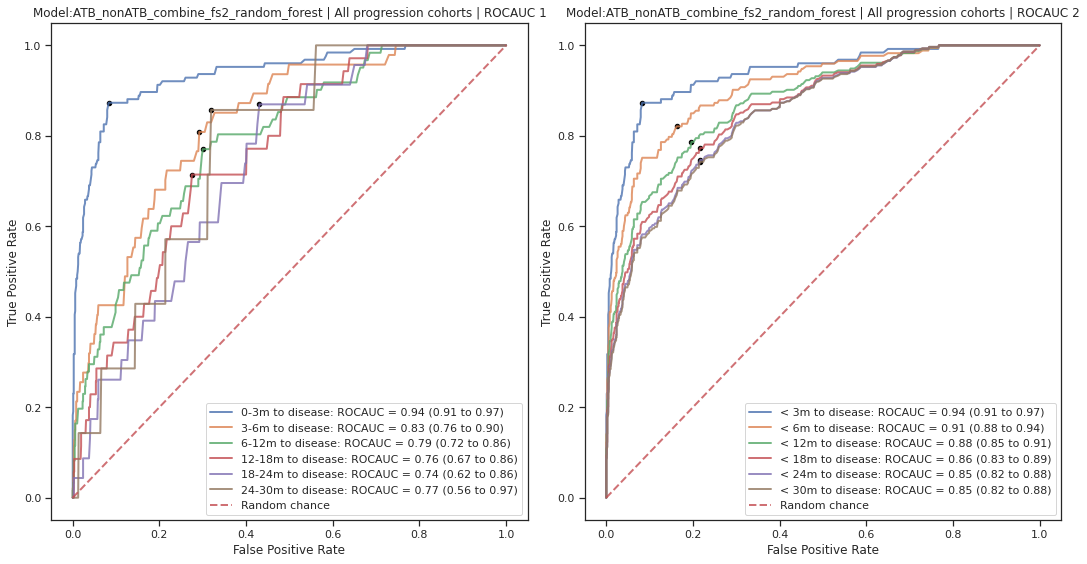

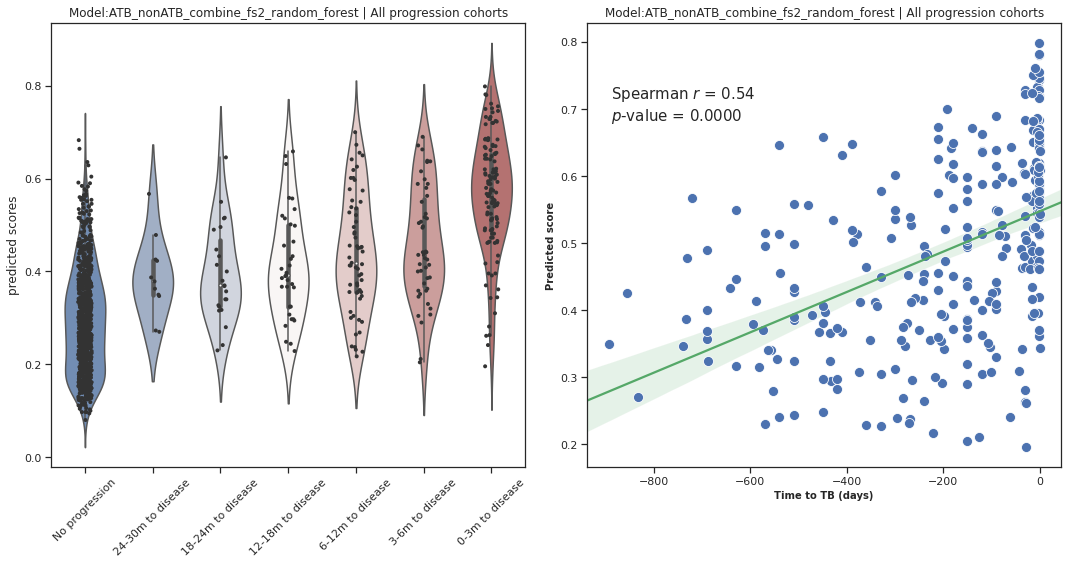

Based on the cutoff defined by maximal youndn Index from ROCAUC curve
                                                              Sensitivity            Specificity                    PPV                    NPV
ATB_nonATB_combine_fs2_random_forest_< 3m to di...  0.873 (0.815 - 0.931)  0.917 (0.899 - 0.935)  0.177 (0.145 - 0.209)  0.997 (0.996 - 0.998)
ATB_nonATB_combine_fs2_random_forest_< 6m to di...  0.821 (0.764 - 0.878)  0.838 (0.813 - 0.862)  0.093 (0.081 - 0.106)  0.996 (0.995 - 0.997)
ATB_nonATB_combine_fs2_random_forest_< 12m to d...  0.786 (0.734 - 0.839)  0.803 (0.777 - 0.830)  0.075 (0.066 - 0.085)  0.995 (0.994 - 0.995)
ATB_nonATB_combine_fs2_random_forest_< 18m to d...  0.773 (0.723 - 0.823)  0.783 (0.756 - 0.810)  0.068 (0.060 - 0.076)  0.994 (0.993 - 0.995)
ATB_nonATB_combine_fs2_random_forest_< 24m to d...  0.747 (0.697 - 0.796)  0.783 (0.756 - 0.810)  0.066 (0.058 - 0.073)  0.993 (0.993 - 0.994)
ATB_nonATB_combine_fs2_random_forest_< 30m to d...  0.742 (0.693 - 0.792

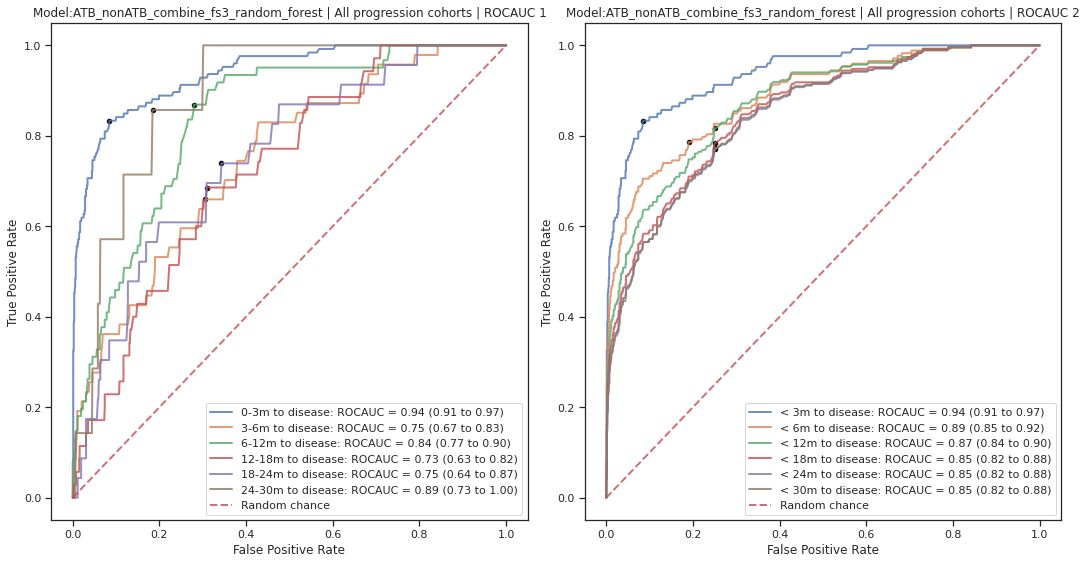

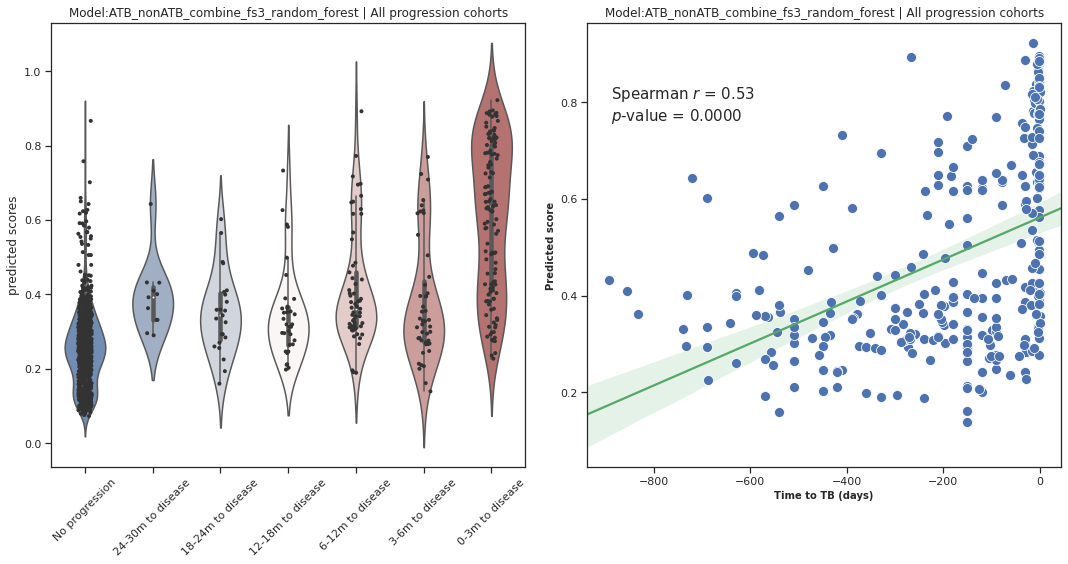

Based on the cutoff defined by maximal youndn Index from ROCAUC curve
                                                              Sensitivity            Specificity                    PPV                    NPV
ATB_nonATB_combine_fs3_random_forest_< 3m to di...  0.833 (0.768 - 0.898)  0.916 (0.898 - 0.934)  0.168 (0.138 - 0.199)  0.996 (0.995 - 0.997)
ATB_nonATB_combine_fs3_random_forest_< 6m to di...  0.786 (0.725 - 0.847)  0.810 (0.784 - 0.836)  0.078 (0.068 - 0.088)  0.995 (0.994 - 0.996)
ATB_nonATB_combine_fs3_random_forest_< 12m to d...  0.816 (0.767 - 0.866)  0.749 (0.720 - 0.778)  0.062 (0.056 - 0.069)  0.995 (0.994 - 0.996)
ATB_nonATB_combine_fs3_random_forest_< 18m to d...  0.784 (0.735 - 0.834)  0.749 (0.720 - 0.778)  0.060 (0.053 - 0.066)  0.994 (0.993 - 0.995)
ATB_nonATB_combine_fs3_random_forest_< 24m to d...  0.771 (0.722 - 0.819)  0.749 (0.720 - 0.778)  0.059 (0.053 - 0.065)  0.994 (0.993 - 0.995)
ATB_nonATB_combine_fs3_random_forest_< 30m to d...  0.773 (0.725 - 0.820

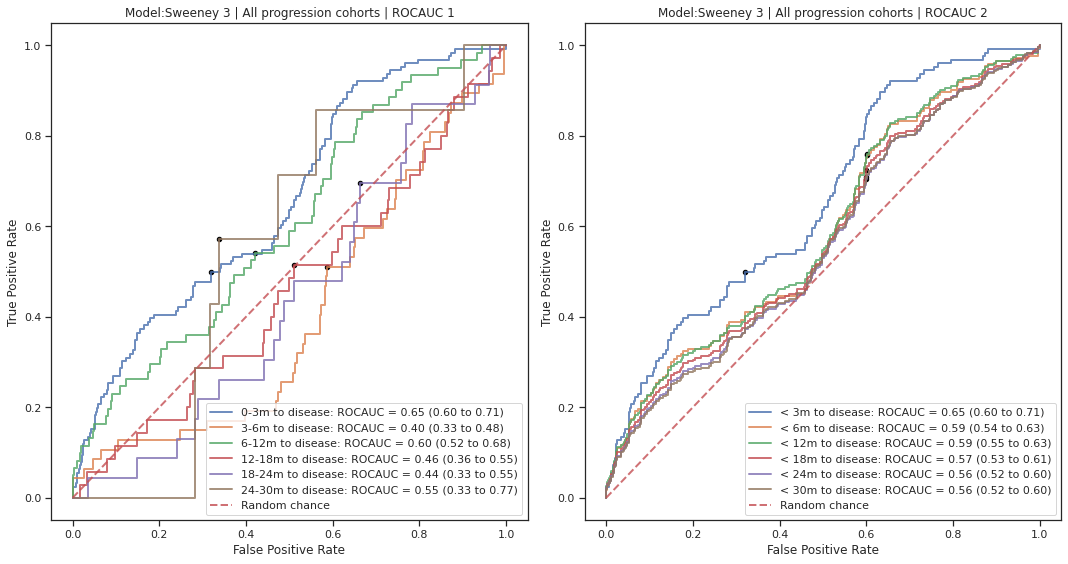

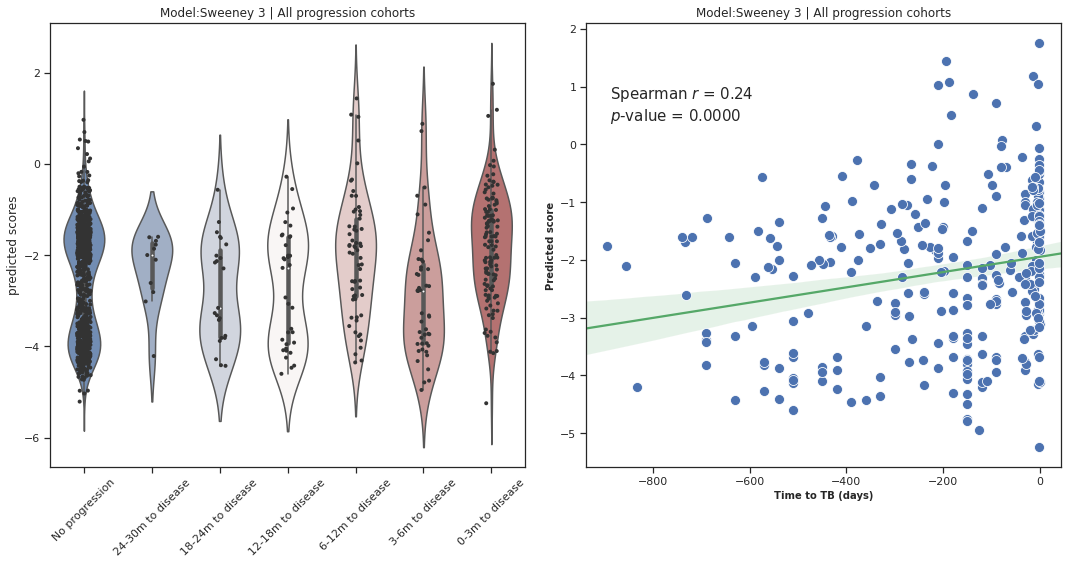

Based on the cutoff defined by maximal youndn Index from ROCAUC curve
                                      Sensitivity            Specificity                    PPV                    NPV
Sweeney 3_< 3m to disease   0.500 (0.413 - 0.587)  0.681 (0.650 - 0.711)  0.031 (0.028 - 0.034)  0.985 (0.984 - 0.987)
Sweeney 3_< 6m to disease   0.757 (0.693 - 0.821)  0.399 (0.367 - 0.431)  0.025 (0.024 - 0.027)  0.988 (0.987 - 0.989)
Sweeney 3_< 12m to disease  0.761 (0.706 - 0.815)  0.398 (0.365 - 0.430)  0.025 (0.024 - 0.027)  0.988 (0.987 - 0.989)
Sweeney 3_< 18m to disease  0.725 (0.672 - 0.778)  0.401 (0.369 - 0.434)  0.024 (0.023 - 0.026)  0.986 (0.985 - 0.987)
Sweeney 3_< 24m to disease  0.705 (0.653 - 0.758)  0.401 (0.369 - 0.434)  0.023 (0.022 - 0.025)  0.985 (0.984 - 0.986)
Sweeney 3_< 30m to disease  0.709 (0.658 - 0.761)  0.401 (0.369 - 0.434)  0.024 (0.022 - 0.025)  0.985 (0.984 - 0.987)
                                       Sensitivity            Specificity                    PPV 

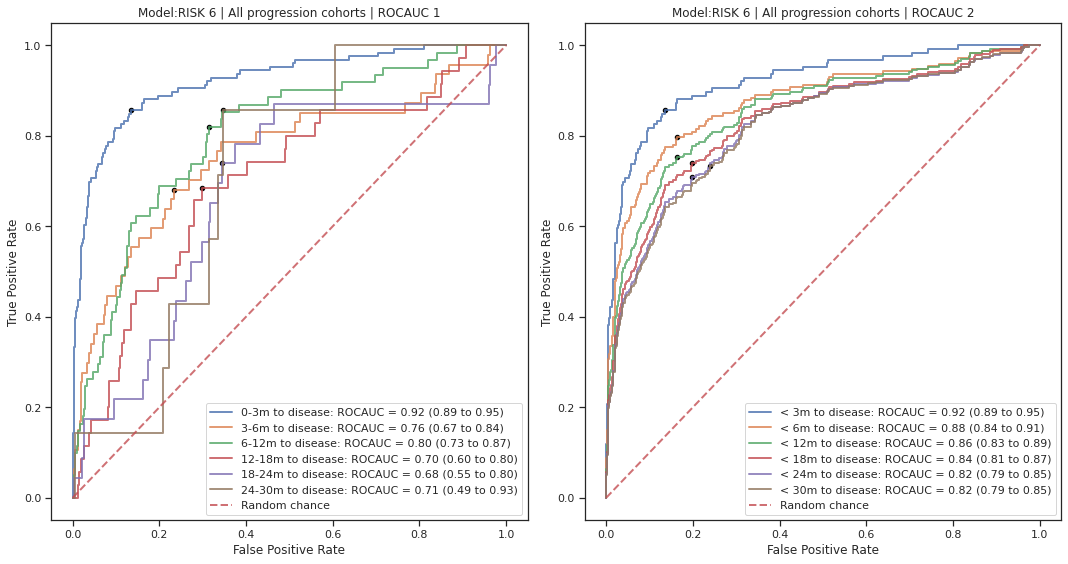

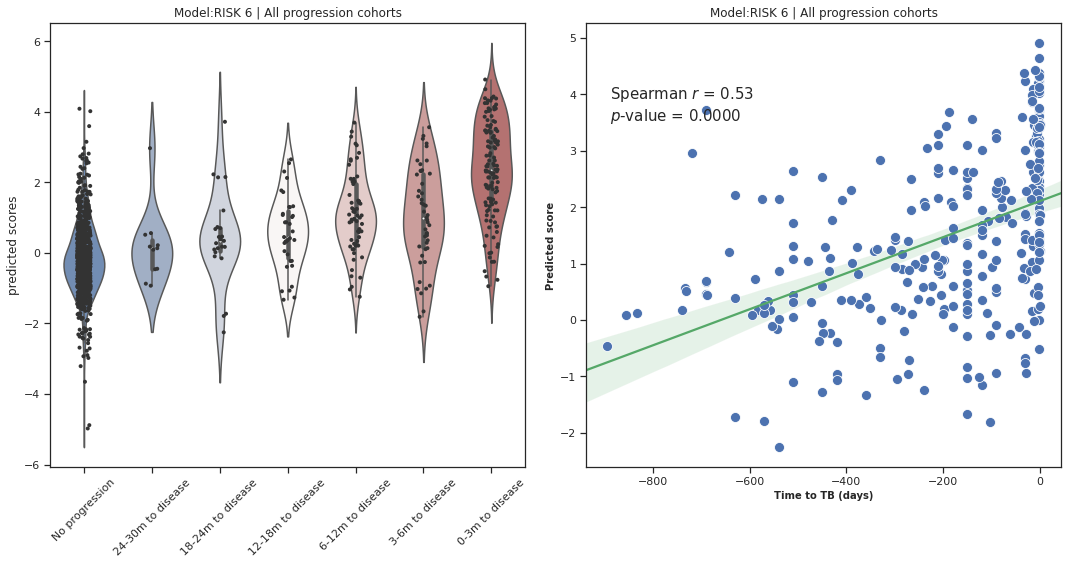

Based on the cutoff defined by maximal youndn Index from ROCAUC curve
                                   Sensitivity            Specificity                    PPV                    NPV
RISK 6_< 3m to disease   0.857 (0.796 - 0.918)  0.865 (0.842 - 0.887)  0.115 (0.098 - 0.131)  0.997 (0.996 - 0.998)
RISK 6_< 6m to disease   0.798 (0.738 - 0.858)  0.836 (0.812 - 0.861)  0.090 (0.078 - 0.103)  0.995 (0.994 - 0.996)
RISK 6_< 12m to disease  0.752 (0.697 - 0.807)  0.836 (0.812 - 0.861)  0.086 (0.074 - 0.097)  0.994 (0.993 - 0.995)
RISK 6_< 18m to disease  0.740 (0.687 - 0.792)  0.801 (0.775 - 0.828)  0.071 (0.062 - 0.079)  0.993 (0.993 - 0.994)
RISK 6_< 24m to disease  0.709 (0.657 - 0.761)  0.801 (0.775 - 0.828)  0.068 (0.059 - 0.076)  0.993 (0.992 - 0.993)
RISK 6_< 30m to disease  0.732 (0.682 - 0.783)  0.761 (0.733 - 0.790)  0.059 (0.052 - 0.065)  0.993 (0.992 - 0.994)
                                    Sensitivity            Specificity                    PPV                    NPV
R

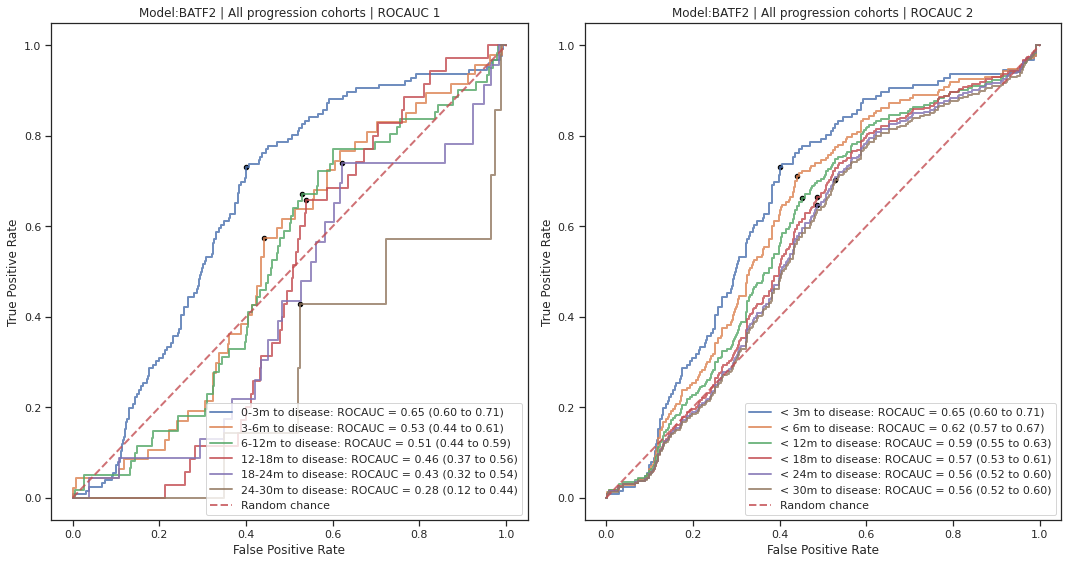

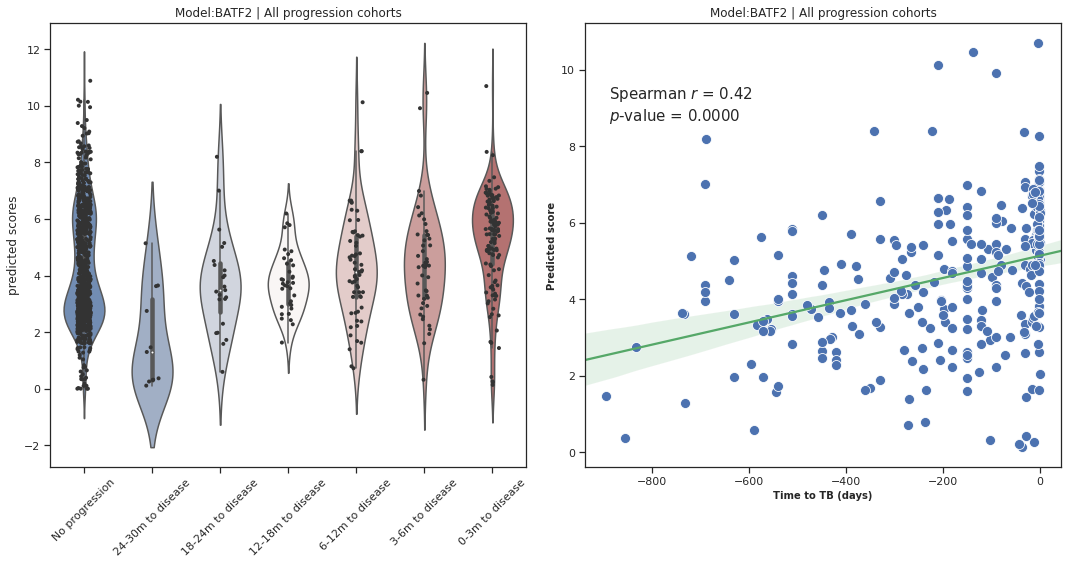

Based on the cutoff defined by maximal youndn Index from ROCAUC curve
                                  Sensitivity            Specificity                    PPV                    NPV
BATF2_< 3m to disease   0.730 (0.653 - 0.808)  0.600 (0.568 - 0.632)  0.036 (0.033 - 0.039)  0.991 (0.990 - 0.992)
BATF2_< 6m to disease   0.711 (0.643 - 0.779)  0.559 (0.526 - 0.592)  0.032 (0.029 - 0.034)  0.990 (0.989 - 0.991)
BATF2_< 12m to disease  0.662 (0.602 - 0.723)  0.549 (0.516 - 0.582)  0.029 (0.027 - 0.031)  0.988 (0.987 - 0.989)
BATF2_< 18m to disease  0.665 (0.609 - 0.722)  0.514 (0.481 - 0.547)  0.027 (0.025 - 0.029)  0.987 (0.986 - 0.988)
BATF2_< 24m to disease  0.647 (0.592 - 0.702)  0.514 (0.481 - 0.547)  0.026 (0.025 - 0.028)  0.986 (0.985 - 0.987)
BATF2_< 30m to disease  0.702 (0.651 - 0.754)  0.472 (0.439 - 0.505)  0.026 (0.025 - 0.028)  0.987 (0.986 - 0.988)
                                   Sensitivity            Specificity                    PPV                    NPV
BATF2_0-3

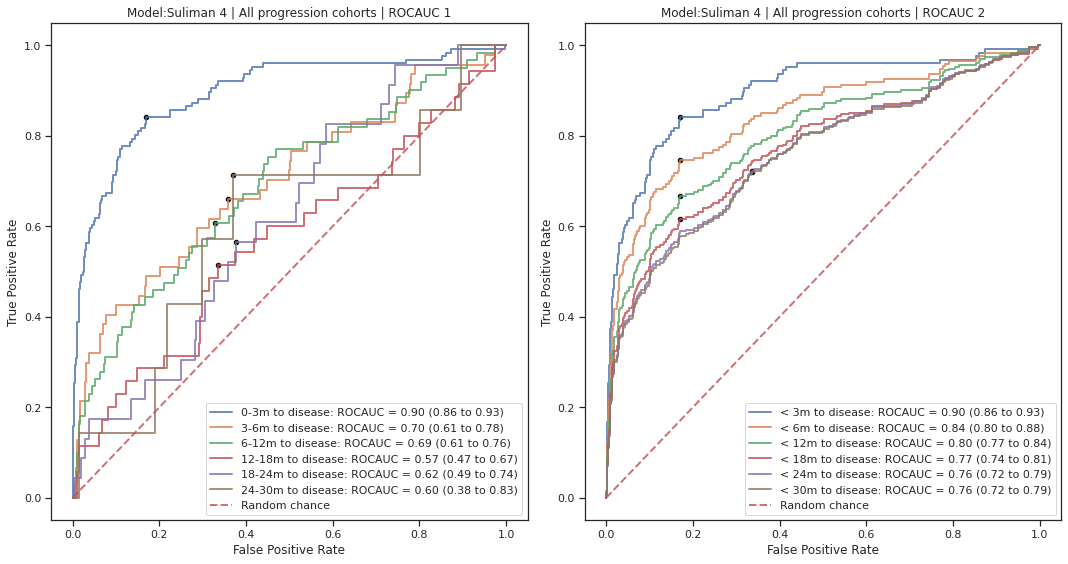

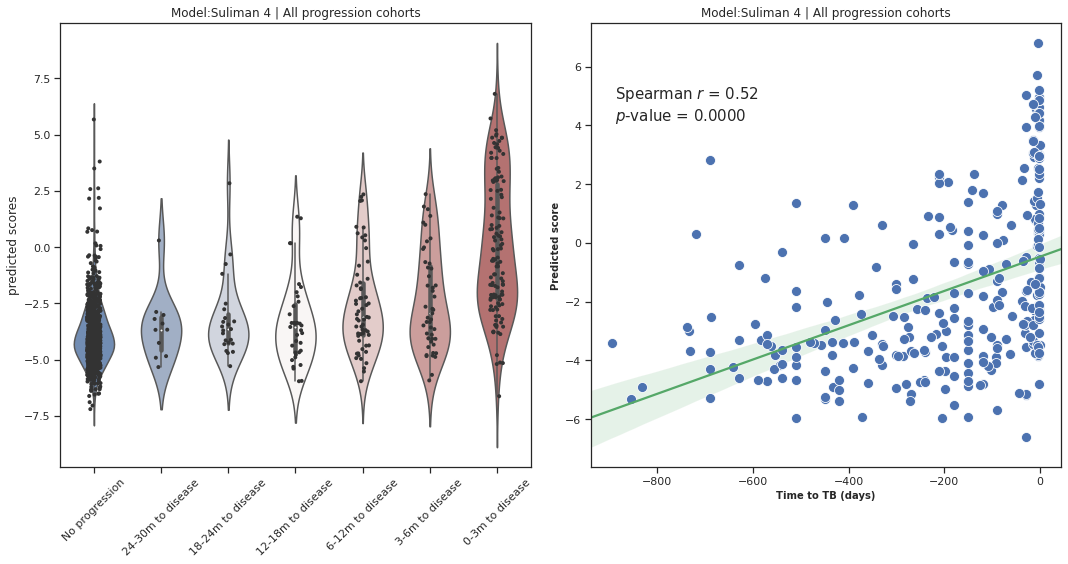

Based on the cutoff defined by maximal youndn Index from ROCAUC curve
                                      Sensitivity            Specificity                    PPV                    NPV
Suliman 4_< 3m to disease   0.841 (0.777 - 0.905)  0.831 (0.806 - 0.855)  0.092 (0.080 - 0.104)  0.996 (0.995 - 0.997)
Suliman 4_< 6m to disease   0.746 (0.681 - 0.811)  0.831 (0.806 - 0.855)  0.082 (0.071 - 0.094)  0.994 (0.993 - 0.995)
Suliman 4_< 12m to disease  0.667 (0.606 - 0.727)  0.831 (0.806 - 0.855)  0.074 (0.064 - 0.084)  0.992 (0.991 - 0.993)
Suliman 4_< 18m to disease  0.617 (0.559 - 0.675)  0.831 (0.806 - 0.855)  0.069 (0.060 - 0.079)  0.991 (0.990 - 0.992)
Suliman 4_< 24m to disease  0.723 (0.671 - 0.774)  0.665 (0.634 - 0.696)  0.042 (0.038 - 0.046)  0.992 (0.991 - 0.992)
Suliman 4_< 30m to disease  0.719 (0.668 - 0.770)  0.665 (0.634 - 0.696)  0.042 (0.038 - 0.046)  0.991 (0.991 - 0.992)
                                       Sensitivity            Specificity                    PPV 

In [53]:
rocauc_m=pd.DataFrame([]);prog_Y_m_o=pd.DataFrame([]);prog_C_m_o=pd.DataFrame([]);prog_Y_m_e=pd.DataFrame([]);prog_C_m_e=pd.DataFrame([])
for modelID in model_list.index:
    modelN=model_list.loc[modelID,'Group type']+'_'+'fs'+str(model_list.loc[modelID,'Fea selection type'])+'_'+model_list.loc[modelID,'ML type']
    #load model
    select_fea,final_model,select_ml=gval.load_ml_model(
        model_list.loc[modelID,'Group type']+'_fs_'+str(model_list.loc[modelID,'Fea selection type'])+'_'+model_list.loc[modelID,'ML type'], final_ml_dir)
    #collect all progression cohorts data
    progress_info, progress_gset=gval.process_progression_cohorts(valdata_dir, datasets, select_fea, rescale, 1)
    #TB progression scores predicted between LTBI and TB incidence
    pred,rocaucs,progs_Youden_olap,progs_cont_olap,progs_Youden_exclu,progs_cont_exclu=gval.progress_assess(modelN, final_model, progress_info, progress_gset, 'Model:'+modelN+' | All progression cohorts', publication_dir+'/model_validation_fig1_'+modelN)
    pred.to_csv(final_ml_dir+'/Com_progress_pred_'+modelN+'.csv',index=True)
    rocauc_m=pd.concat([rocauc_m,rocaucs])
    prog_Y_m_o=pd.concat([prog_Y_m_o,progs_Youden_olap])
    prog_C_m_o=pd.concat([prog_C_m_o,progs_cont_olap])
    prog_Y_m_e=pd.concat([prog_Y_m_e,progs_Youden_exclu])
    prog_C_m_e=pd.concat([prog_C_m_e,progs_cont_exclu])
    with pd.option_context('display.max_rows', None, 'display.max_columns', None,'expand_frame_repr', False):  
        print('Based on the cutoff defined by maximal youndn Index from ROCAUC curve')
        print(progs_Youden_olap)
        print(progs_Youden_exclu)
        print('Based on the cutoff using 97.5th percentile of the IGRA-negative control population')
        print(progs_cont_olap)
        print(progs_cont_exclu)
for modelID in pubmodel_list.index:
    modelN=pubmodel_list.loc[modelID,'model']
    select_fea=pubmodel_list.loc[modelID,'features'].split(',')
    #collect all progression cohorts data
    progress_info, progress_gset=gval.process_progression_cohorts(valdata_dir, datasets, select_fea, 0, 0)
    pred,rocaucs,progs_Youden_olap,progs_cont_olap,progs_Youden_exclu,progs_cont_exclu=gval.progress_assess(modelN, final_model, progress_info, progress_gset, 'Model:'+modelN+' | All progression cohorts', publication_dir+'/model_validation_fig1_'+modelN, pubmodel=1)
    pred.to_csv(final_ml_dir+'/Com_progress_pred_'+modelN+'.csv',index=True)
    rocauc_m=pd.concat([rocauc_m,rocaucs])
    prog_Y_m_o=pd.concat([prog_Y_m_o,progs_Youden_olap])
    prog_C_m_o=pd.concat([prog_C_m_o,progs_cont_olap])
    prog_Y_m_e=pd.concat([prog_Y_m_e,progs_Youden_exclu])
    prog_C_m_e=pd.concat([prog_C_m_e,progs_cont_exclu])
    with pd.option_context('display.max_rows', None, 'display.max_columns', None,'expand_frame_repr', False):  
        print('Based on the cutoff defined by maximal youndn Index from ROCAUC curve')
        print(progs_Youden_olap)
        print(progs_Youden_exclu)
        print('Based on the cutoff using 97.5th percentile of the IGRA-negative control population')
        print(progs_cont_olap)
        print(progs_cont_exclu)

rocauc_m.to_csv(publication_dir+'/validation_combined_progress_cohorts_rocaucs.csv',index=True)
prog_Y_m_o.to_csv(publication_dir+'/validation_combined_progress_cohorts_prognosis_metrics_YoundenInd_overlap.csv',index=True)
prog_C_m_o.to_csv(publication_dir+'/validation_combined_progress_cohorts_prognosis_metrics_controlPopu_overlap.csv',index=True)
prog_Y_m_e.to_csv(publication_dir+'/validation_combined_progress_cohorts_prognosis_metrics_YoundenInd_exclusive.csv',index=True)
prog_C_m_e.to_csv(publication_dir+'/validation_combined_progress_cohorts_prognosis_metrics_controlPopu_exclusive.csv',index=True)

In [54]:
rocauc_m

,0-3m to disease,3-6m to disease,6-12m to disease,12-18m to disease,18-24m to disease,24-30m to disease,< 3m to disease,< 6m to disease,< 12m to disease,< 18m to disease,< 24m to disease,< 30m to disease
ATB_nonATB_combine_fs2_random_forest,0.94 (0.91 to 0.97),0.83 (0.76 to 0.90),0.79 (0.72 to 0.86),0.76 (0.67 to 0.86),0.74 (0.62 to 0.86),0.77 (0.56 to 0.97),0.94 (0.91 to 0.97),0.91 (0.88 to 0.94),0.88 (0.85 to 0.91),0.86 (0.83 to 0.89),0.85 (0.82 to 0.88),0.85 (0.82 to 0.88)
ATB_nonATB_combine_fs3_random_forest,0.94 (0.91 to 0.97),0.75 (0.67 to 0.83),0.84 (0.77 to 0.90),0.73 (0.63 to 0.82),0.75 (0.64 to 0.87),0.89 (0.73 to 1.00),0.94 (0.91 to 0.97),0.89 (0.85 to 0.92),0.87 (0.84 to 0.90),0.85 (0.82 to 0.88),0.85 (0.82 to 0.88),0.85 (0.82 to 0.88)
Sweeney 3,0.65 (0.60 to 0.71),0.40 (0.33 to 0.48),0.60 (0.52 to 0.68),0.46 (0.36 to 0.55),0.44 (0.33 to 0.55),0.55 (0.33 to 0.77),0.65 (0.60 to 0.71),0.59 (0.54 to 0.63),0.59 (0.55 to 0.63),0.57 (0.53 to 0.61),0.56 (0.52 to 0.60),0.56 (0.52 to 0.60)
RISK 6,0.92 (0.89 to 0.95),0.76 (0.67 to 0.84),0.80 (0.73 to 0.87),0.70 (0.60 to 0.80),0.68 (0.55 to 0.80),0.71 (0.49 to 0.93),0.92 (0.89 to 0.95),0.88 (0.84 to 0.91),0.86 (0.83 to 0.89),0.84 (0.81 to 0.87),0.82 (0.79 to 0.85),0.82 (0.79 to 0.85)
BATF2,0.65 (0.60 to 0.71),0.53 (0.44 to 0.61),0.51 (0.44 to 0.59),0.46 (0.37 to 0.56),0.43 (0.32 to 0.54),0.28 (0.12 to 0.44),0.65 (0.60 to 0.71),0.62 (0.57 to 0.67),0.59 (0.55 to 0.63),0.57 (0.53 to 0.61),0.56 (0.52 to 0.60),0.56 (0.52 to 0.60)
Suliman 4,0.90 (0.86 to 0.93),0.70 (0.61 to 0.78),0.69 (0.61 to 0.76),0.57 (0.47 to 0.67),0.62 (0.49 to 0.74),0.60 (0.38 to 0.83),0.90 (0.86 to 0.93),0.84 (0.80 to 0.88),0.80 (0.77 to 0.84),0.77 (0.74 to 0.81),0.76 (0.72 to 0.79),0.76 (0.72 to 0.79)


## 4. Combine all TB data and develop a TB progression risk model 
#### 4.1 Also consider model classification performance between active TB vs viral infection 

In [55]:
#Collect the training data
X,Y=gpmod.TBexpressiondata(nor_exp_data,plot=0,alpha=0.2,rescale=0)#Remove genes not included in >20% of the traning datasets
#Use HC, LTBI, ATB and OD from the training data
fY_train=Y.loc[(Y.Status=='ATB')|(Y.Status=='LTBI')|(Y.Status=='OD')|(Y.Status=='HC'),:]
fY_train['group'] = fY_train['Status'].apply(gpmod.scaleStatusOutcome)#Based on binary classification for ML
fY_train['Cond'] = fY_train['Status'].apply(gpmod.scaleQuantOutcome)# Based on actual status classification
fX_train=X.loc[:,fY_train.index]

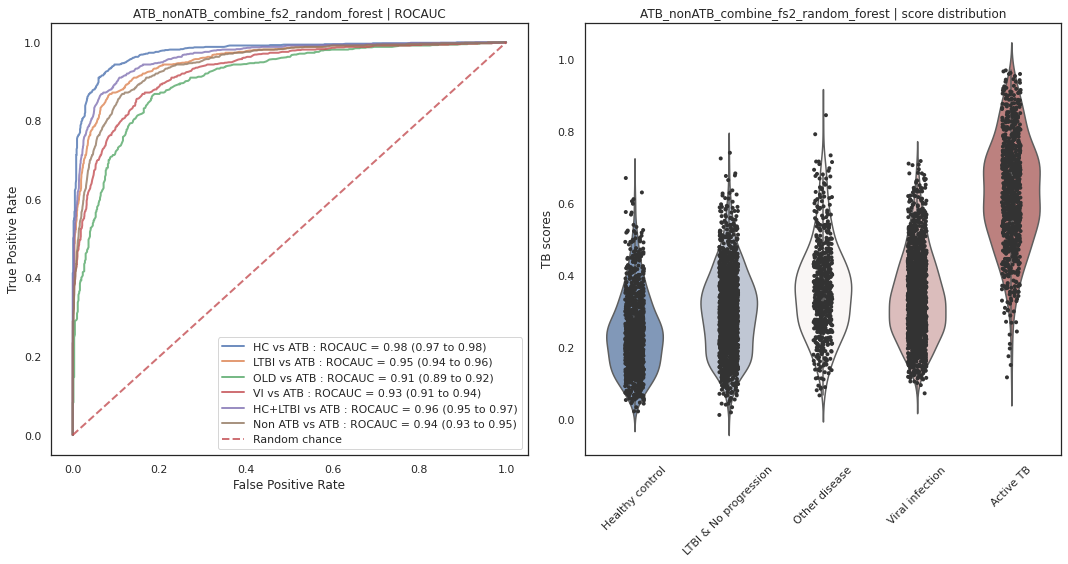

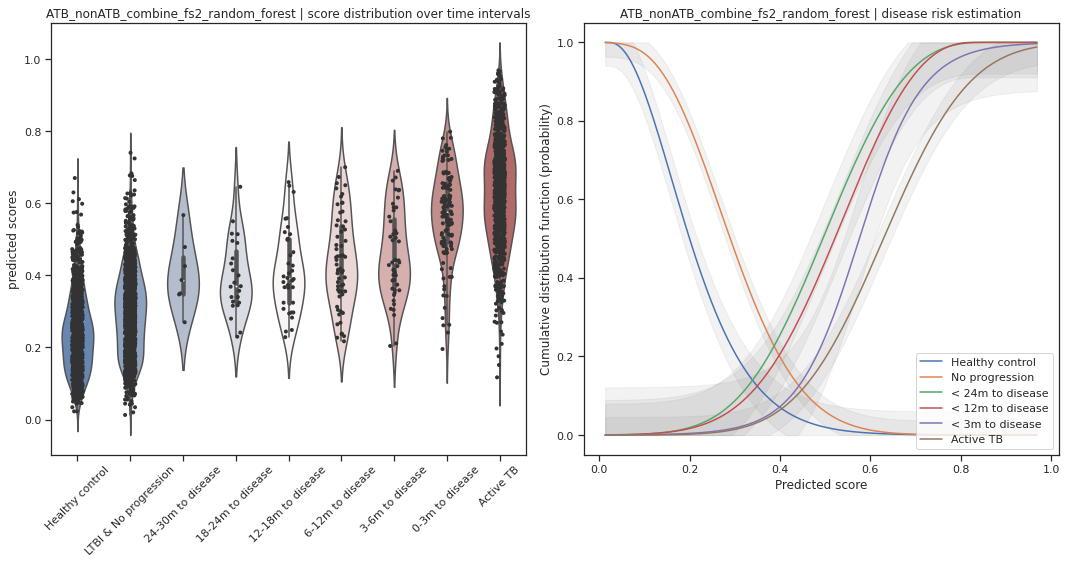

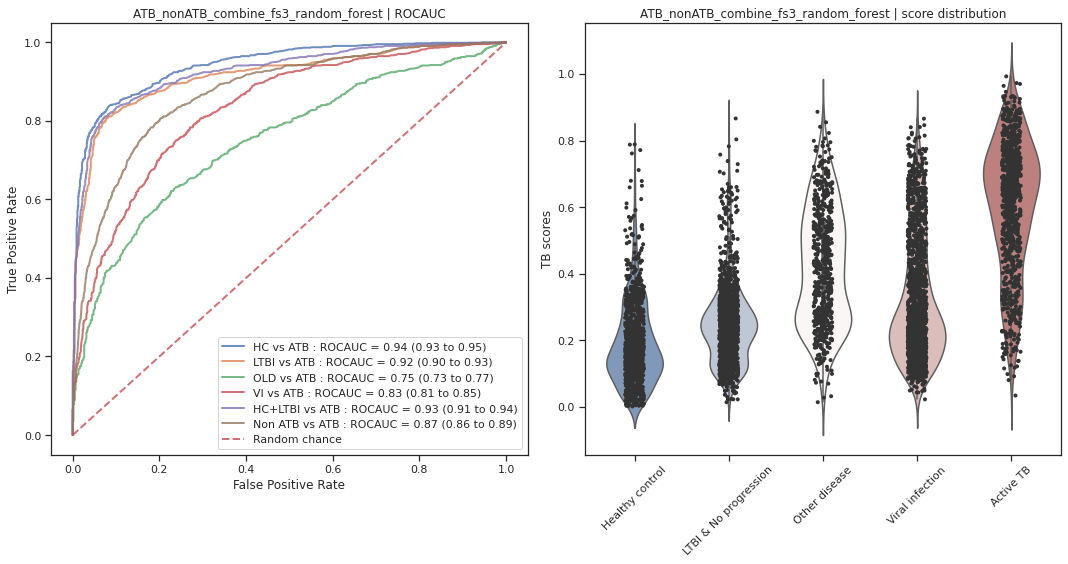

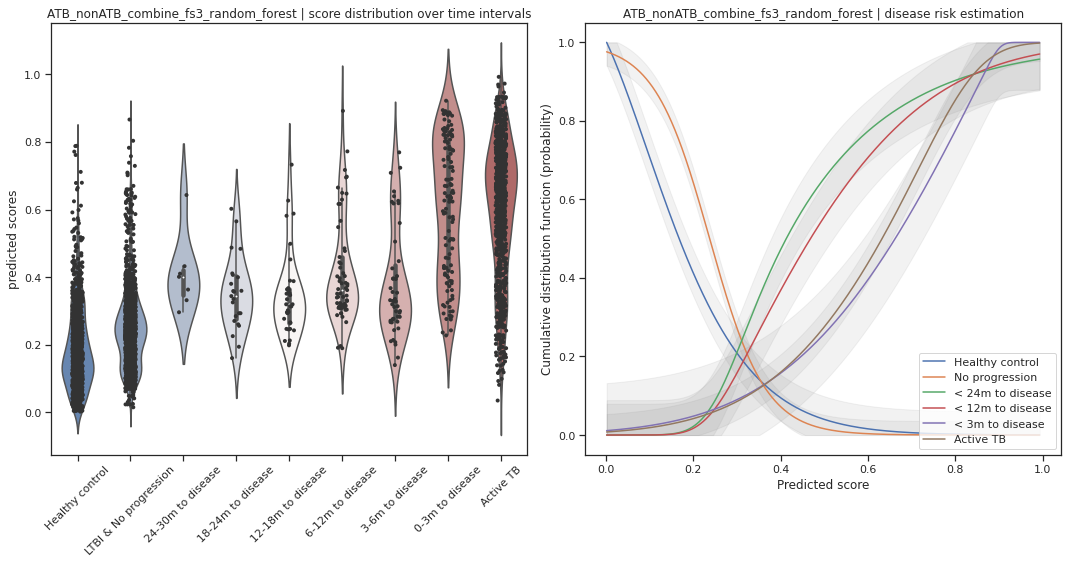

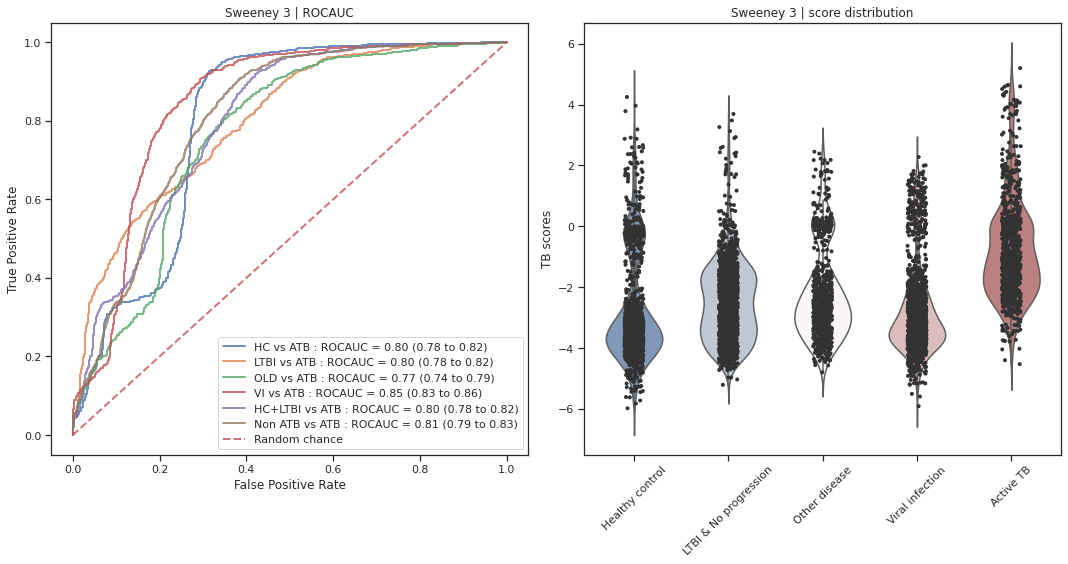

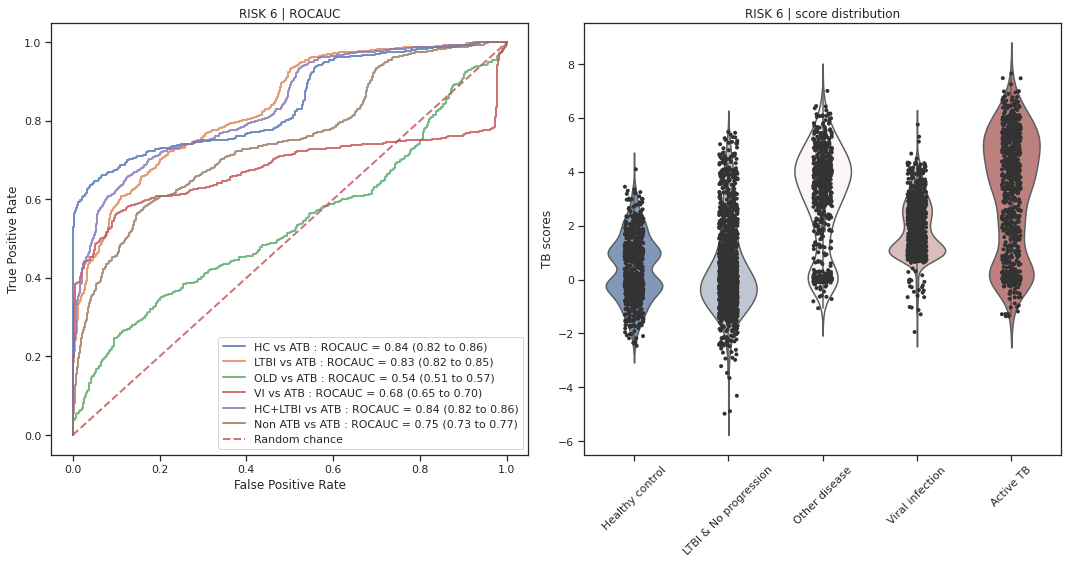

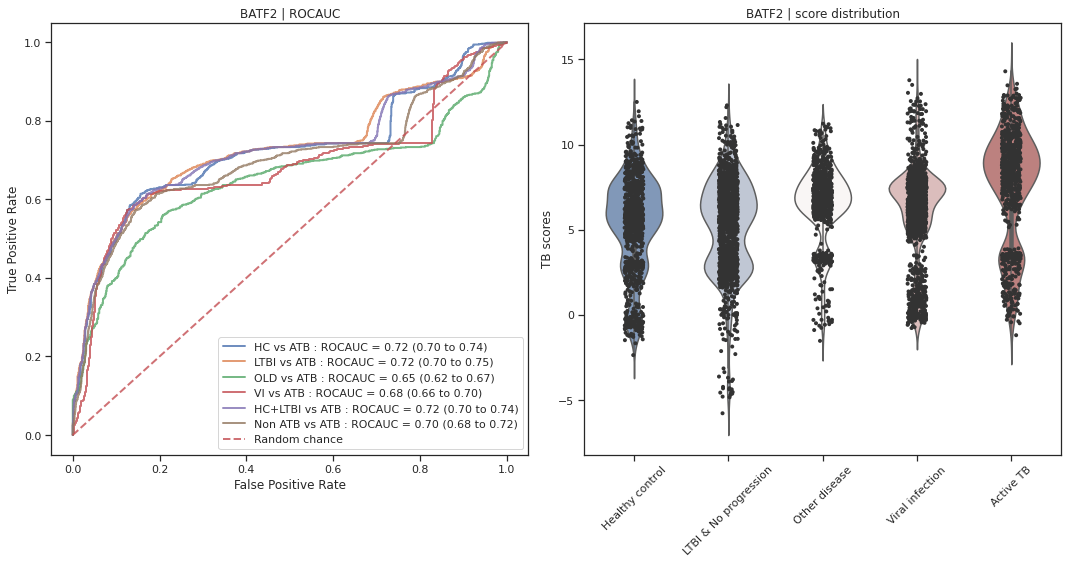

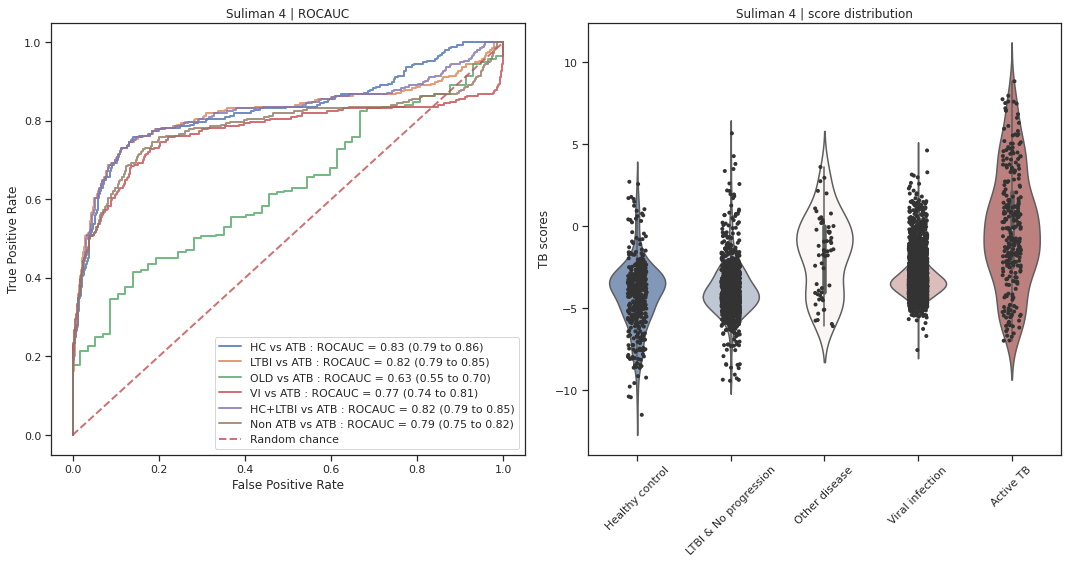

In [58]:
def diagonsis_risk_estimation(modelN,final_model,fX_train,fY_train,select_fea,valdata_dir,publication_dir,datasets,rescale,pubmodel,pair,dist,ylim,pmodel):
    fX_train = gval.valdata_process(fX_train,select_fea,rescale=rescale,pair=pair,recover=0)
    fY_train = fY_train.loc[fX_train.index,:]#required if some of samples are removed
    if pubmodel==1:#calculate model score based on the published model
        preds_t=gval.modelscore(fY_train, fX_train, pubmodel=pubmodel, model=modelN)
    else:
        preds_t=gval.modelscore(fY_train, fX_train, pubmodel=pubmodel, model=final_model)
    #Collect all validation data
    fY_val, fX_val=gval.process_progression_cohorts(valdata_dir, datasets, select_fea, rescale, pair)
    if pubmodel==1:#calculate model score based on the published model
        preds_v=gval.modelscore(fY_val, fX_val, pubmodel=pubmodel, model=modelN)
    else:
        preds_v=gval.modelscore(fY_val, fX_val, pubmodel=pubmodel, model=final_model)
    #Merge two prediced matrices
    preds, preds_alt=gval.TBprogress_data_integrate(preds_t, preds_v)
    #Test model proformance to separate active TB from viral infection (focus on respiratory infection)
    fY_viral, fX_viral=gval.viral_infect_dataset(valdata_dir+'/viral-infection-dataset', select_fea, rescale, pair)
    fY_viral['Status']='Viral infection';fY_viral.loc[fY_viral['disease']=='healthy','Status']='Healthy control'
    fX_viral=fX_viral.loc[fY_viral.index,:]
    if pubmodel==1:#calculate model score based on the published model
        preds_viral=gval.modelscore(fY_viral, fX_viral, pubmodel=pubmodel, model=modelN)
    else:
        preds_viral=gval.modelscore(fY_viral, fX_viral, pubmodel=pubmodel, model=final_model)
    #Add viral infection to sample collection for model performance calculation
    preds=pd.concat([preds,preds_viral.loc[:,['Status','Y_pred']]])
    preds.loc[preds['Status']=='Healthy control','group']=0
    #Test model proformance to separate active TB from control/latent infection/other lung disease  
    gval.TB_diagonsis(preds,modelN,publication_dir+'/model_validation_fig2_'+modelN)
    if pmodel==1:
        #Generate probabilistic models based on different risk levels
        pdfT, cdfT=gval.TBprog_model(preds, preds_alt, modelN, publication_dir+'/model_validation_fig2_'+modelN,
                                     predefine_range=[preds['Y_pred'].min(),preds['Y_pred'].max()],dist=dist,ylim=ylim)
    return preds
  
for modelID in model_list.index:
    modelN=model_list.loc[modelID,'Group type']+'_'+'fs'+str(model_list.loc[modelID,'Fea selection type'])+'_'+model_list.loc[modelID,'ML type']
    select_fea,final_model,select_ml=gval.load_ml_model(
        model_list.loc[modelID,'Group type']+'_fs_'+str(model_list.loc[modelID,'Fea selection type'])+'_'+model_list.loc[modelID,'ML type'], final_ml_dir)  
    preds = diagonsis_risk_estimation(modelN,final_model,fX_train,fY_train,select_fea,valdata_dir,publication_dir,datasets,rescale,0,1,2,0,1)
    preds.to_csv(publication_dir+'/TB_disease_prediction_'+modelN+'.csv',index=True)
for modelID in pubmodel_list.index:
    modelN=pubmodel_list.loc[modelID,'model']
    select_fea=pubmodel_list.loc[modelID,'features'].split(',')
    preds = diagonsis_risk_estimation(modelN,'',fX_train,fY_train,select_fea,valdata_dir,publication_dir,datasets,0,1,0,1,0,0)
    preds.to_csv(publication_dir+'/TB_disease_prediction_'+modelN+'.csv',index=True)